# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/final.sqlite" "final.sqlite"

In [0]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
print("Preprocessed Amzon fine food data columns  shape : ",final.shape)
print("fPreprocessed Amzon fine food data columns       :",final.columns.values)

Preprocessed Amzon fine food data columns  shape :  (364171, 12)
fPreprocessed Amzon fine food data columns       : ['index' 'Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

preprocessed_reviews=final['CleanedText'][:40000]
score=final['Score'][:40000]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size=0.2, random_state=42)

In [0]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=500) #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bow))
print("the shape of out text BOW vectorizer ",X_test_bow.get_shape())
print("the number of unique words ", X_test_bow.get_shape()[1])

some feature names  ['abl', 'absolut', 'actual', 'ad', 'add', 'addict', 'addit', 'ago', 'allergi', 'alreadi']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (32000, 500)
the number of unique words  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (8000, 500)
the number of unique words  500


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_bow)
X_train_tfidf=scaler.transform(X_train_bow)

X_test_tfidf=scaler.transform(X_test_bow)	

In [0]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.model_selection import RandomizedSearchCV
clf=RandomForestClassifier()
param_grid={'n_estimators' :  [5, 10, 50, 100, 200, 500, 1000] , 'max_depth' :  [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gcv=RandomizedSearchCV(clf,param_grid,cv=10,scoring='roc_auc')
gcv.fit(X_train_bow,y_train)
print(gcv.best_params_)
print(gcv.best_score_)
        
optimal_depth          =  gcv.best_params_['max_depth']
optimal_estimators     =  gcv.best_params_['n_estimators']

{'n_estimators': 500, 'max_depth': 8}
0.8349917055482534


[2, 3, 2, 8, 3, 6, 8, 8, 8, 7]
[500, 50, 10, 500, 200, 1000, 50, 200, 100, 100]
[82.0, 81.0, 72.0, 87.0, 82.0, 85.0, 86.0, 87.0, 86.0, 86.0]
[82.0, 81.0, 72.0, 83.0, 82.0, 83.0, 83.0, 83.0, 83.0, 83.0]
ploting 3d grap
ploting Heat Map


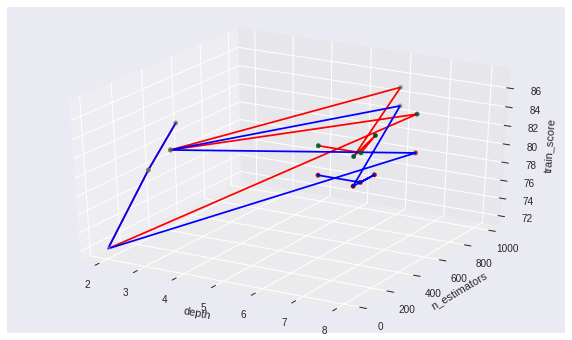

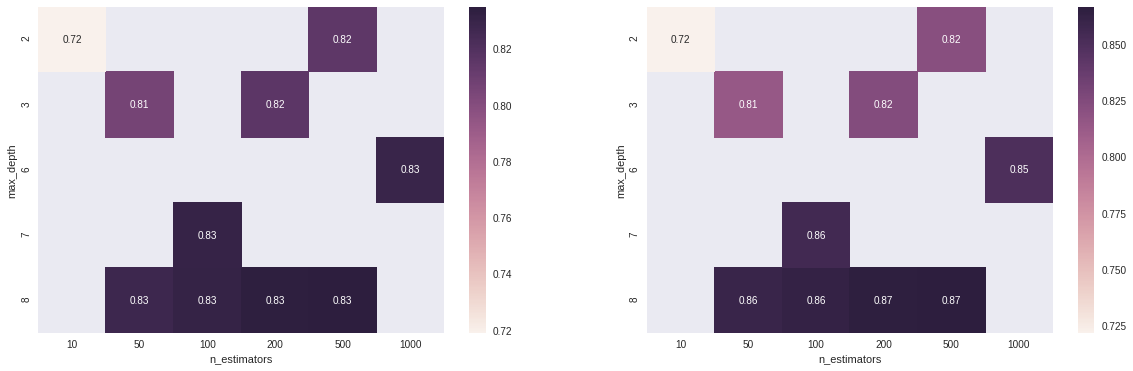

In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")



print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()


In [0]:
df_params

,max_depth,n_estimators
0,2,500
1,3,50
2,2,10
3,8,500
4,3,200
5,6,1000
6,8,50
7,8,200
8,8,100
9,7,100


Accuracy Score :  84.475
Precision Score :  84.46917594097786
Recall Score :  100.0
F1 Score :  91.58080260303689
        
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1245
           1       0.84      1.00      0.92      6755

   micro avg       0.84      0.84      0.84      8000
   macro avg       0.92      0.50      0.46      8000
weighted avg       0.87      0.84      0.77      8000

        
AUC Score for train data : 0.8634610585217078
AUC Score for test data : 0.8313486068626839
        


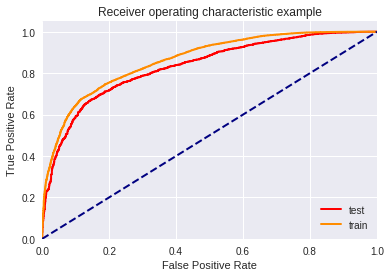

       

TrueNegative : 3
FalsePostive : 1242
FalseNegative : 0
TruePostive  :  6755
        
        


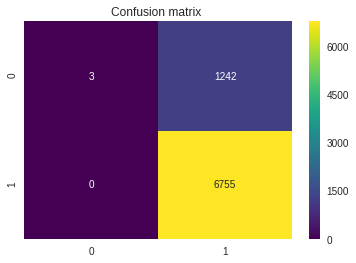

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
clf1.fit(X_train_bow,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_bow, y_train)

pred = sig_clf.predict_proba(X_test_bow)[:,1]
pred_train = sig_clf.predict_proba(X_train_bow)[:,1]


pred_train_without_CCV=clf1.predict(X_train_bow)
pred_without_CCV=clf1.predict(X_test_bow)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

['great', 'love', 'product', 'tast', 'like', 'veri', 'best', 'use', 'just', 'good', 'tri', 'flavor', 'did', 'order', 'dog', 'food', 'onli', 'time', 'buy', 'didnt']


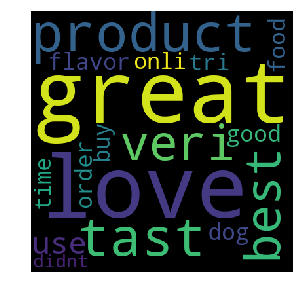

In [0]:
-np.sort(-clf1.feature_importances_)[:20]


features=count_vect.get_feature_names()
imp=clf1.feature_importances_.argsort()[::-1][:20]
top20Features=[features[i] for i in imp]
top20Features
print(top20Features)

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

wordcloud = WordCloud(width = 400, height = 400, background_color ='black',  min_font_size = 10).generate(' '.join(top20Features))
  
# plot the WordCloud image                        
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
#a=clf1.feature_importances_.tolist()
#a.sort()
#print(a[::-1][:20])

#np.sort(clf1.feature_importances_,)[::-1][:20]
-np.sort(-clf1.feature_importances_)[:20]


features=count_vect.get_feature_names()
imp=clf1.feature_importances_.tolist()

print([i for i in zip(features,imp)])

df=pd.DataFrame([features,imp],index=['feature','values'])
df=df.T
df1=df.sort_values('values',ascending=False)


print(len(imp))
len(features)
df1[:20]

[('add', 0.0044907245051340255), ('alway', 0.005562703837472016), ('amazon', 0.011375769641162808), ('ani', 0.008867427638205094), ('bag', 0.011957502425203879), ('becaus', 0.011379591450007774), ('befor', 0.007818718892939955), ('best', 0.01733912219391957), ('better', 0.00970499625723798), ('bit', 0.006421830449315), ('bottl', 0.005776588192260454), ('bought', 0.010886069038605832), ('box', 0.0116585777737473), ('brand', 0.009106228894106803), ('buy', 0.012825606305026584), ('cat', 0.008625360953580512), ('chocol', 0.0076941147605365445), ('coffe', 0.00802058840060532), ('come', 0.00670895188303685), ('cup', 0.004773157060938061), ('day', 0.010783424858340338), ('delici', 0.008656993874789555), ('did', 0.01518543524674542), ('didnt', 0.012730591258581524), ('differ', 0.007830141246172519), ('doe', 0.007108266224982648), ('dog', 0.014413099010717306), ('dont', 0.012216358128775744), ('drink', 0.006819678635322799), ('eat', 0.012032961522191878), ('enjoy', 0.007394028816938018), ('ever

,feature,values
38,great,0.0281393
52,love,0.0271193
68,product,0.0253931
85,tast,0.0229765
46,like,0.0203779
93,veri,0.0174872
7,best,0.0173391
92,use,0.0168953
44,just,0.0167899
36,good,0.0167356


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:
#BoW
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=500) #in scikit-learn
tf_idf_vect.fit(X_train)
print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text BOW vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words ", X_train_tfidf.get_shape()[1])

X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text BOW vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words ", X_test_tfidf.get_shape()[1])

some feature names  ['abl', 'absolut', 'actual', 'ad', 'add', 'addict', 'addit', 'ago', 'allergi', 'alreadi']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (32000, 500)
the number of unique words  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (8000, 500)
the number of unique words  500


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_tfidf)
X_train_tfidf=scaler.transform(X_train_tfidf)

X_test_tfidf=scaler.transform(X_test_tfidf)	

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
param_grid={'n_estimators' : [5, 10, 50, 100, 200, 500, 1000], 'max_depth' :  [2,3,4,5,6,7,8,9,10]}
gcv=RandomizedSearchCV(clf,param_grid,cv=3,scoring='roc_auc')
gcv.fit(X_train_tfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)
        
optimal_depth          =  gcv.best_params_['max_depth']
optimal_estimators     =  gcv.best_params_['n_estimators']

{'n_estimators': 500, 'max_depth': 8}
0.8380049265304902


[4, 3, 5, 4, 8, 2, 10, 2, 5, 5]
[5, 1000, 10, 500, 500, 10, 50, 100, 200, 100]
[74.0, 84.0, 81.0, 85.0, 90.0, 72.0, 91.0, 83.0, 86.0, 86.0]
[73.0, 83.0, 78.0, 83.0, 84.0, 71.0, 83.0, 81.0, 83.0, 83.0]
ploting 3d grap
ploting Heat Map


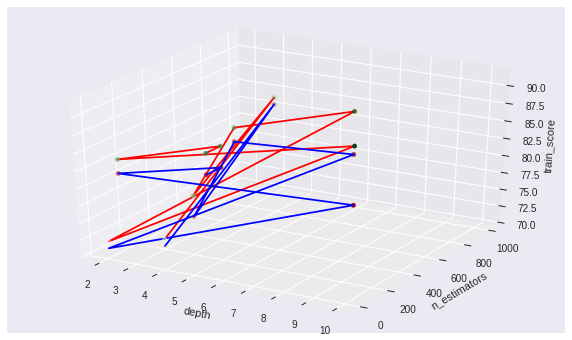

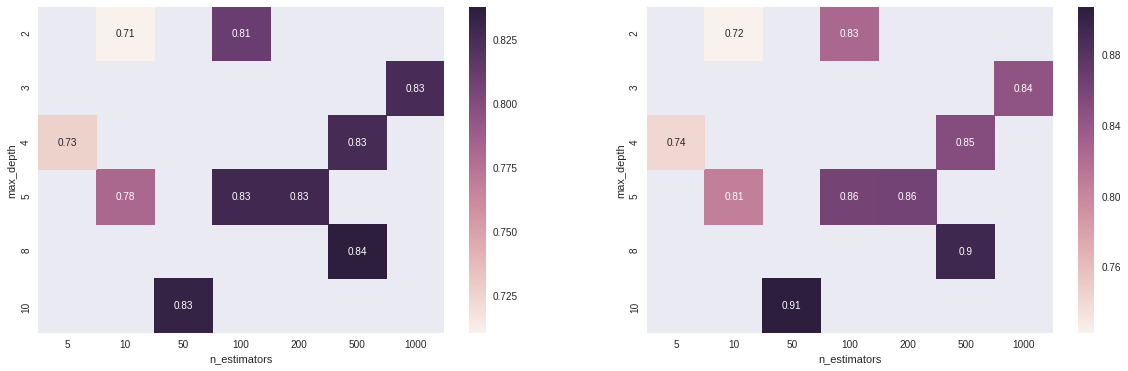

In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")



print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()


Accuracy Score :  84.475
Precision Score :  84.46917594097786
Recall Score :  100.0
F1 Score :  91.58080260303689
        
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1245
           1       0.84      1.00      0.92      6755

   micro avg       0.84      0.84      0.84      8000
   macro avg       0.92      0.50      0.46      8000
weighted avg       0.87      0.84      0.77      8000

        
AUC Score for train data : 0.8839775262242905
AUC Score for test data : 0.8352311392126611
        


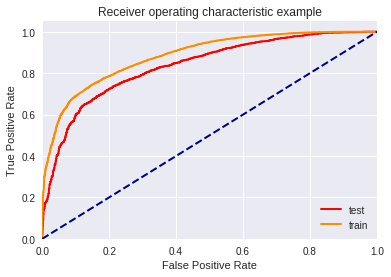

       

TrueNegative : 3
FalsePostive : 1242
FalseNegative : 0
TruePostive  :  6755
        
        


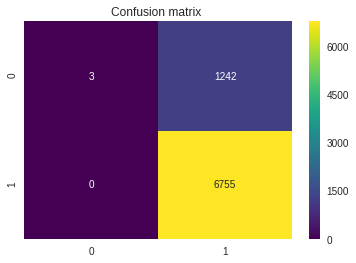

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
clf1.fit(X_train_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_tfidf, y_train)

pred = sig_clf.predict_proba(X_test_tfidf)[:,1]
pred_train = sig_clf.predict_proba(X_train_tfidf)[:,1]


pred_train_without_CCV=clf1.predict(X_train_tfidf)
pred_without_CCV=clf1.predict(X_test_tfidf)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


In [0]:
#a=clf1.feature_importances_.tolist()
#a.sort()
#print(a[::-1][:20])

#np.sort(clf1.feature_importances_,)[::-1][:20]
-np.sort(-clf1.feature_importances_)[:20]


features=tf_idf_vect.get_feature_names()
imp=clf1.feature_importances_.tolist()

print([i for i in zip(features,imp)])

df=pd.DataFrame([features,imp],index=['feature','values'])
df=df.T
df1=df.sort_values('values',ascending=False)


print(len(imp))
len(features)
df1[:20]

[('add', 0.0036903995227348463), ('alway', 0.0044586750682233615), ('amazon', 0.010896183579977261), ('ani', 0.008210415758523602), ('bag', 0.011480623241144334), ('becaus', 0.01279874107483174), ('befor', 0.008126347047916848), ('best', 0.017997773316035234), ('better', 0.008804955168016194), ('bit', 0.005243049916200226), ('bottl', 0.004964951720351965), ('bought', 0.01193696001172303), ('box', 0.01475350401097236), ('brand', 0.0083073330491009), ('buy', 0.017129248443937692), ('cat', 0.006406308139799676), ('chocol', 0.0062173004384017795), ('coffe', 0.006433342300903258), ('come', 0.005856093181462949), ('cup', 0.003770108046549947), ('day', 0.00883747459641144), ('delici', 0.008717022932292246), ('did', 0.02062809882318903), ('didnt', 0.016910863563391554), ('differ', 0.0069146712019609435), ('doe', 0.007316823686131514), ('dog', 0.013281702886759646), ('dont', 0.016560344242231788), ('drink', 0.005074627530016528), ('eat', 0.011732615274007131), ('enjoy', 0.006856006982804618), (

,feature,values
38,great,0.0319556
52,love,0.0317364
68,product,0.0287589
85,tast,0.0274627
46,like,0.0225693
36,good,0.0213083
22,did,0.0206281
93,veri,0.0181137
7,best,0.0179978
92,use,0.0176706


### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

['great', 'love', 'product', 'tast', 'like', 'good', 'did', 'veri', 'best', 'use', 'just', 'buy', 'didnt', 'dont', 'flavor', 'tri', 'box', 'order', 'onli', 'look']


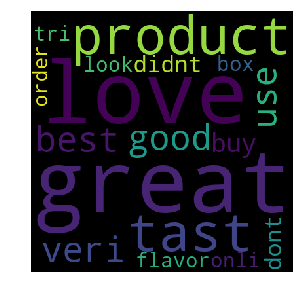

In [0]:
# Please write all the code with proper documentation
-np.sort(-clf1.feature_importances_)[:20]


features=tf_idf_vect.get_feature_names()
imp=clf1.feature_importances_.argsort()[::-1][:20]
top20Features=[features[i] for i in imp]
top20Features
print(top20Features)

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

wordcloud = WordCloud(width = 400, height = 400, background_color ='black',  min_font_size = 10).generate(' '.join(top20Features))
  
# plot the WordCloud image                        
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
	
	
#*******************************************************************************************

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
		
#*******************************************************************************************

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_train_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_AvgW2V.append(sent_vec)
print(len(X_train_AvgW2V))
print(len(X_train_AvgW2V[0]))
#*********************************************************************************************



  0%|          | 35/32000 [00:00<01:33, 343.50it/s]

[('wonder', 0.8224478363990784), ('excel', 0.8194332122802734), ('fantast', 0.7982593178749084), ('good', 0.769319474697113), ('awesom', 0.7685434818267822), ('perfect', 0.7560844421386719), ('terrif', 0.7159143686294556), ('amaz', 0.6943674087524414), ('decent', 0.6431294679641724), ('fabul', 0.6373891830444336)]
[('best', 0.7055174112319946), ('closest', 0.6775582432746887), ('horribl', 0.658958911895752), ('disgust', 0.6368822455406189), ('tastiest', 0.6175901293754578), ('greatest', 0.6026514768600464), ('terribl', 0.5906044244766235), ('aw', 0.5675726532936096), ('superior', 0.5543636083602905), ('biggest', 0.5535221695899963)]
number of words that occured minimum 5 times  8343
sample words  ['this', 'product', 'better', 'than', 'ani', 'have', 'tri', 'the', 'pure', 'white', 'powder', 'and', 'doe', 'not', 'filler', 'best', 'valu', 'wasabi', 'pea', 'out', 'there', 'bag', 'repres', 'lot', 'but', 'leav', 'work', 'theyll', 'soon', 'disappear', 'tasti', 'first', 'had', 'cooki', 'airlin'

100%|██████████| 32000/32000 [01:31<00:00, 349.25it/s]

32000
50


In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
	
#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_test_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_AvgW2V.append(sent_vec)
print(len(X_test_AvgW2V))
print(len(X_test_AvgW2V[0]))

100%|██████████| 8000/8000 [00:23<00:00, 340.84it/s]

8000
50


In [0]:
len(X_train_AvgW2V),len(X_test_AvgW2V)

(32000, 8000)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
param_grid={'n_estimators' :  [5, 10, 50, 100, 200, 500, 1000], 'max_depth' :  [2,3,4,5,6,7,8,9,10]}
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_AvgW2V,y_train)
print(gcv.best_params_)
print(gcv.best_score_)
        
optimal_depth          =  gcv.best_params_['max_depth']
optimal_estimators     =  gcv.best_params_['n_estimators']

In [0]:
from sklearn.ensemble import RandomForestClassifier
from  sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
param_grid={'n_estimators' :  [5, 10, 50, 100, 200, 500, 1000], 'max_depth' :  [2,3,4,5,6,7,8,9,10]}
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_AvgW2V,y_train)
print(gcv.best_params_)
print(gcv.best_score_)
        
optimal_depth          =  gcv.best_params_['max_depth']
optimal_estimators     =  gcv.best_params_['n_estimators']

{'max_depth': 10, 'n_estimators': 100}
0.8668456827341905


[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10]
[5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000, 5, 10, 50, 100, 200, 500, 1000]
[77.0, 78.0, 81.0, 81.0, 81.0, 81.0, 81.0, 80.0, 81.0, 83.0, 83.0, 83.0, 83.0, 83.0, 82.0, 83.0, 85.0, 85.0, 85.0, 85.0, 85.0, 83.0, 85.0, 86.0, 87.0, 87.0, 87.0, 87.0, 85.0, 87.0, 88.0, 89.0, 89.0, 89.0, 89.0, 87.0, 89.0, 91.0, 91.0, 91.0, 91.0, 91.0, 90.0, 92.0, 93.0, 94.0, 94.0, 94.0, 94.0, 92.0, 94.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 96.0, 98.0, 98.0, 98.0, 98.0, 98.0]
[77.0, 77.0, 80.0, 80.0, 80.0, 81.0, 81.0, 79.0, 80.0, 82.0, 82.0, 82.0, 82.0, 82.0, 80.0, 82.0, 83.0, 83.0, 83.0, 83.0, 83.0, 81.0, 82

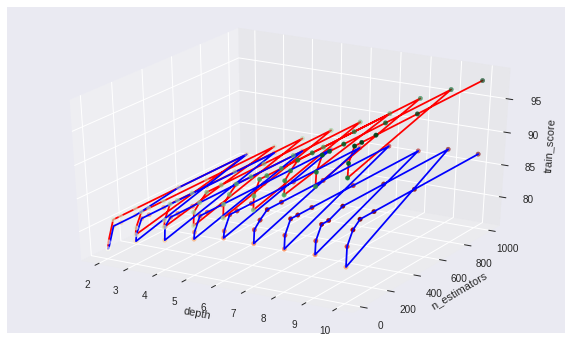

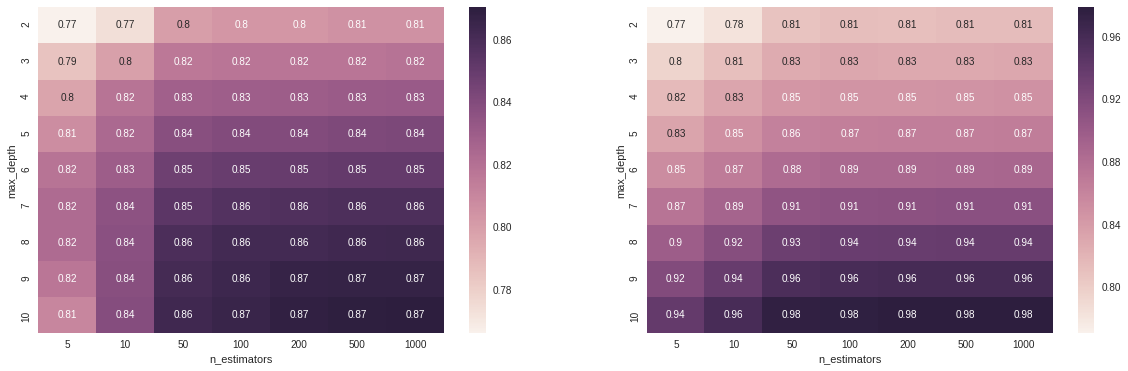

In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()

In [0]:
df3

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,max_depth,n_estimators
0,8.195508,0.064418,0.846148,0.872823,5,100,4,0.842860,0.873138,0.856366,...,0.845262,0.874252,0.832242,0.876456,0.059990,0.000844,0.008616,2.743299e-03,5,100
1,13.915090,0.096795,0.867483,0.979746,10,100,1,0.863694,0.980308,0.880285,...,0.865062,0.980212,0.852717,0.979684,0.030931,0.002476,0.009684,8.284489e-04,10,100
2,18.084755,0.133426,0.865912,1.000000,50,100,3,0.865337,1.000000,0.879493,...,0.861215,1.000000,0.854302,1.000000,0.115986,0.004252,0.008397,0.000000e+00,50,100
3,18.160068,0.131030,0.866421,1.000000,100,100,2,0.863960,1.000000,0.881529,...,0.862213,1.000000,0.853134,1.000000,0.100638,0.003416,0.009508,7.021667e-17,100,100


ploting Heat Map


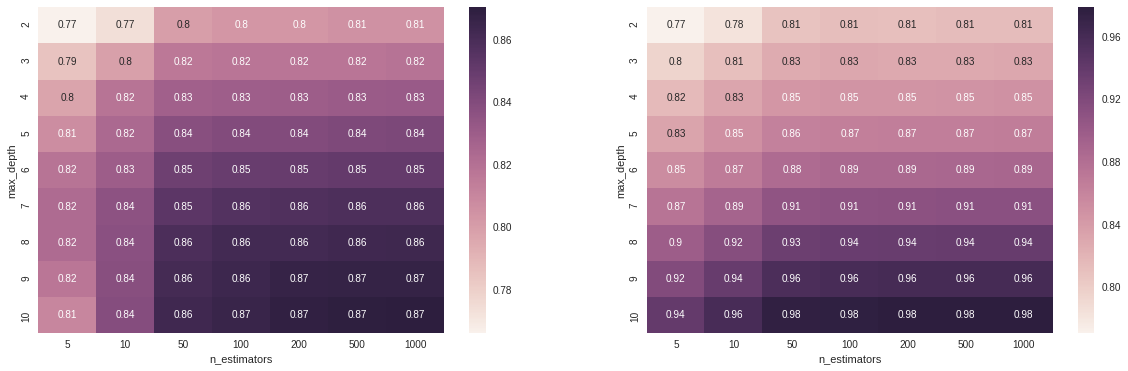

In [0]:
print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()

Accuracy Score :  86.1875
Precision Score :  86.47043635424735
Recall Score :  99.1561806069578
F1 Score :  92.37983587338803
        
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.16      0.26      1245
           1       0.86      0.99      0.92      6755

   micro avg       0.86      0.86      0.86      8000
   macro avg       0.82      0.57      0.59      8000
weighted avg       0.85      0.86      0.82      8000

        
AUC Score for train data : 0.690836067671144
AUC Score for test data : 0.5748973688982428
        


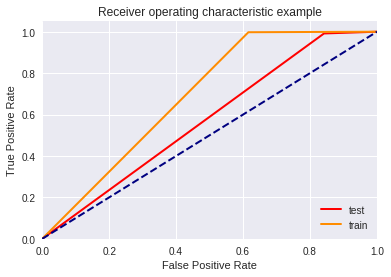

       

TrueNegative : 197
FalsePostive : 1048
FalseNegative : 57
TruePostive  :  6698
        
        


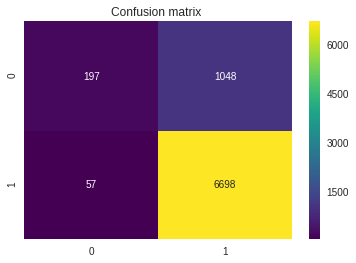

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
clf1.fit(X_train_AvgW2V,y_train)
pred_train=clf1.predict(X_train_AvgW2V)
pred=clf1.predict(X_test_AvgW2V)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

#*********************************************************************************************

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_Avgtfidf.append(sent_vec)
    row += 1

    
#*********************************************************************************************

X_test_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_Avgtfidf.append(sent_vec)
    row += 1


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
clf=RandomForestClassifier()
param_grid={'n_estimators' : np.arange(100,500) , 'max_depth' :  [5, 10, 50, 100]}
gcv=RandomizedSearchCV(clf,param_grid,cv=10,scoring='roc_auc')
gcv.fit(X_train_Avgtfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)
        
optimal_depth          =  gcv.best_params_['max_depth']
optimal_estimators     =  gcv.best_params_['n_estimators']

{'n_estimators': 455, 'max_depth': 50}
0.8466345074231709


[10, 100, 5, 5, 50, 5, 50, 100, 100, 5]
[403, 191, 318, 160, 455, 334, 298, 207, 316, 480]
[97.0, 100.0, 84.0, 84.0, 100.0, 84.0, 100.0, 100.0, 100.0, 84.0]
[84.0, 84.0, 82.0, 82.0, 85.0, 82.0, 84.0, 84.0, 85.0, 82.0]
ploting 3d grap
ploting Heat Map


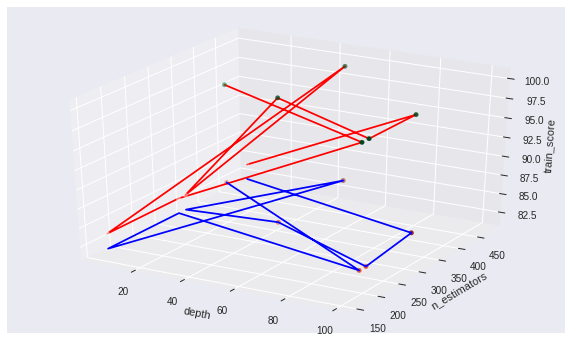

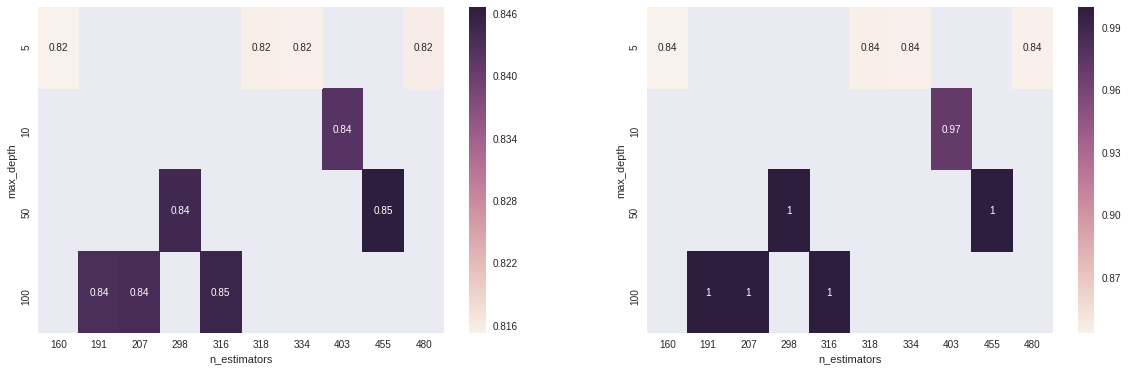

In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()

Accuracy Score :  86.2
Precision Score :  86.45336085666365
Recall Score :  99.20059215396003
F1 Score :  92.38935612849856
        
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.16      0.26      1245
           1       0.86      0.99      0.92      6755

   micro avg       0.86      0.86      0.86      8000
   macro avg       0.82      0.57      0.59      8000
weighted avg       0.85      0.86      0.82      8000

        
AUC Score for train data : 1.0
AUC Score for test data : 0.8386619460818849
        


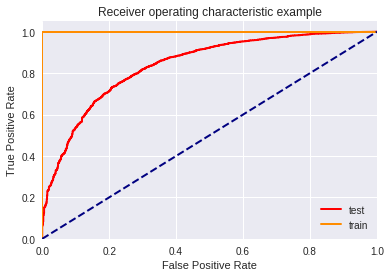

       

TrueNegative : 195
FalsePostive : 1050
FalseNegative : 54
TruePostive  :  6701
        
        


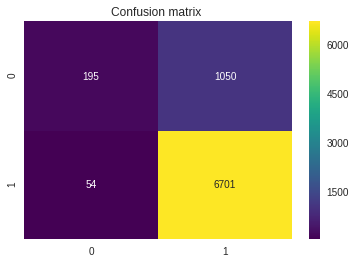

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(n_estimators=455,max_depth=50)
clf1.fit(X_train_Avgtfidf,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_Avgtfidf, y_train)

pred = sig_clf.predict_proba(X_test_Avgtfidf)[:,1]
pred_train = sig_clf.predict_proba(X_train_Avgtfidf)[:,1]


pred_train_without_CCV=clf1.predict(X_train_Avgtfidf)
pred_without_CCV=clf1.predict(X_test_Avgtfidf)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


## [5.2] Applying GBDT using XGBOOST

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

preprocessed_reviews_xg=final['CleanedText'][:100000]
score_xg=final['Score'][:100000]
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(preprocessed_reviews_xg, score_xg, test_size=0.2, random_state=42)

In [0]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=1000) #in scikit-learn
count_vect.fit(X_train_xg)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow_xg = count_vect.transform(X_train_xg)
print("the type of count vectorizer ",type(X_train_bow_xg))
print("the shape of out text BOW vectorizer ",X_train_bow_xg.get_shape())
print("the number of unique words ", X_train_bow_xg.get_shape()[1])

X_test_bow_xg = count_vect.transform(X_test_xg)
print("the type of count vectorizer ",type(X_test_bow_xg))
print("the shape of out text BOW vectorizer ",X_test_bow_xg.get_shape())
print("the number of unique words ", X_test_bow_xg.get_shape()[1])

some feature names  ['abl', 'abov', 'absolut', 'acid', 'actual', 'ad', 'add', 'addict', 'addit', 'admit']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 1000)
the number of unique words  1000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 1000)
the number of unique words  1000


### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

preprocessed_reviews=final['CleanedText'][:40000]
score=final['Score'][:40000]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size=0.2, random_state=42)

In [0]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=1000) #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bow))
print("the shape of out text BOW vectorizer ",X_test_bow.get_shape())
print("the number of unique words ", X_test_bow.get_shape()[1])

some feature names  ['abl', 'abov', 'absolut', 'acid', 'activ', 'actual', 'ad', 'add', 'addict', 'addit']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (32000, 1000)
the number of unique words  1000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (8000, 1000)
the number of unique words  1000


In [0]:
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
clf=GradientBoostingClassifier()
#param_grid={ 'n_estimators' : np.arange(20,200,20),
#             'max_depth' :  [5,10,15,20,30],
#             'learning_rate' : [0.1,0.001] }
param_grid={ 'n_estimators' : [50,100,150,200],
             'max_depth' :  [5,10,20]}
gcv=RandomizedSearchCV(clf,param_grid,cv=5)
gcv.fit(X_train_bow,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'n_estimators': 200, 'max_depth': 10}
0.88846875


[10, 20, 20, 10, 5, 5, 20, 10, 5, 10]
[100, 100, 50, 200, 200, 100, 200, 50, 50, 150]
[95.0, 99.0, 97.0, 97.0, 92.0, 90.0, 100.0, 92.0, 88.0, 96.0]
[88.0, 88.0, 88.0, 89.0, 89.0, 88.0, 88.0, 88.0, 87.0, 89.0]
ploting 3d grap
ploting Heat Map


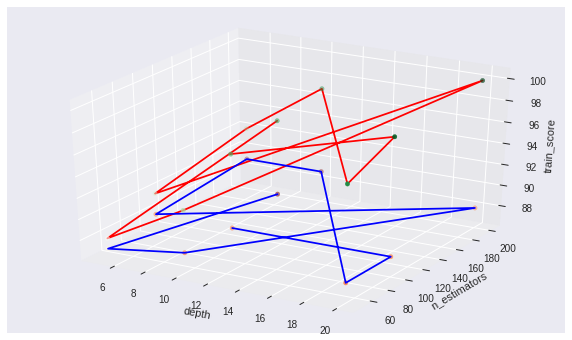

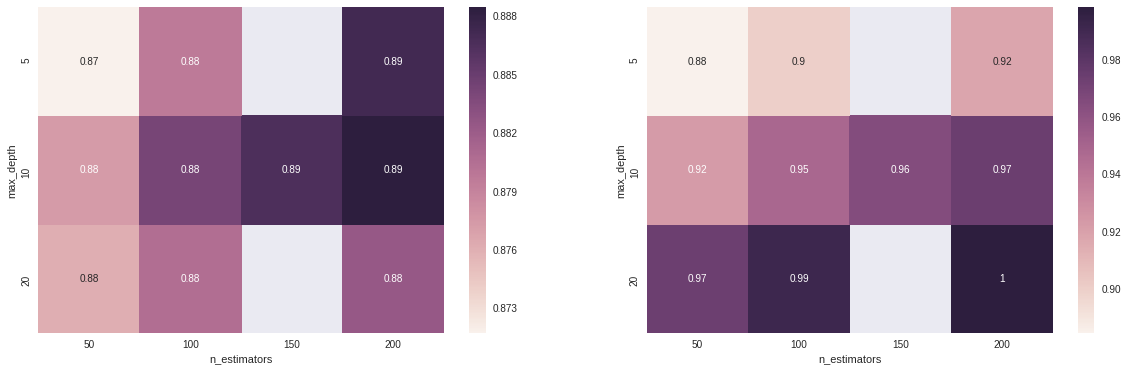

In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()


Accuracy Score :  88.7875
Precision Score :  90.03553854565337
Recall Score :  97.51295336787564
F1 Score :  93.6251865539052
        
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.41      0.53      1245
           1       0.90      0.98      0.94      6755

   micro avg       0.89      0.89      0.89      8000
   macro avg       0.83      0.69      0.74      8000
weighted avg       0.88      0.89      0.87      8000

        
AUC Score for train data : 0.9942886344329558
AUC Score for test data : 0.9056362236510809
        


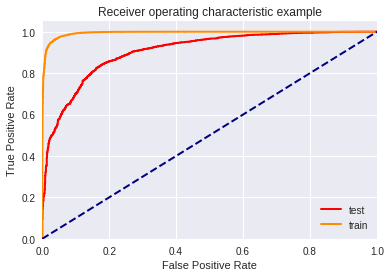

       

TrueNegative : 516
FalsePostive : 729
FalseNegative : 168
TruePostive  :  6587
        
        


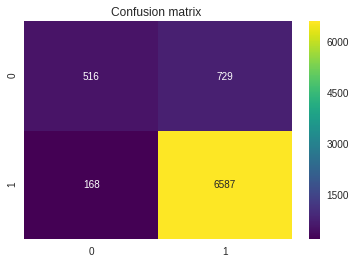

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 



clf1=GradientBoostingClassifier(n_estimators=200,max_depth=10)
clf1.fit(X_train_bow,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_bow, y_train)

pred = sig_clf.predict_proba(X_test_bow)[:,1]
pred_train = sig_clf.predict_proba(X_train_bow)[:,1]


pred_train_without_CCV=clf1.predict(X_train_bow)
pred_without_CCV=clf1.predict(X_test_bow)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


['disappoint', 'money', 'best', 'great', 'love', 'return', 'worst', 'product', 'wast', 'thought', 'refund', 'delici', 'good', 'terribl', 'like', 'veri', 'bad', 'tast', 'use', 'did']


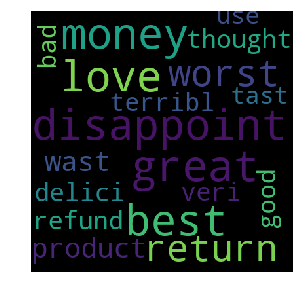

In [0]:

-np.sort(-clf1.feature_importances_)[:20]


features=count_vect.get_feature_names()
imp=clf1.feature_importances_.argsort()[::-1][:20]
top20Features=[features[i] for i in imp]
top20Features
print(top20Features)

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

wordcloud = WordCloud(width = 400, height = 400, background_color ='black',  min_font_size = 10).generate(' '.join(top20Features))
  
# plot the WordCloud image                        
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
#a=clf1.feature_importances_.tolist()
#a.sort()
#print(a[::-1][:20])

#np.sort(clf1.feature_importances_,)[::-1][:20]
-np.sort(-clf1.feature_importances_)[:50]


features=count_vect.get_feature_names()
imp=clf1.feature_importances_.tolist()

print([i for i in zip(features,imp)])

df=pd.DataFrame([features,imp],index=['feature','values'])
df=df.T
df1=df.sort_values('values',ascending=False)


print(len(imp))
len(features)
df1[:20]


[('abl', 0.0010486297363098372), ('abov', 0.00030587842799058236), ('absolut', 0.0004403063975175263), ('acid', 0.0003559398720334647), ('activ', 0.00015431996396337693), ('actual', 0.0016541530301405862), ('ad', 0.0004223788330750723), ('add', 0.0011137720286859745), ('addict', 0.0004915089094309154), ('addit', 0.0001954124339468209), ('adult', 0.00010192457008860951), ('advertis', 0.00045221406748092443), ('aftertast', 0.0012525070616734887), ('age', 0.00036939805953659565), ('ago', 0.001137197840829147), ('agre', 0.0006625316981159775), ('air', 0.0006734883344715388), ('allerg', 0.0004205023233415016), ('allergi', 0.00029281220191165416), ('allow', 0.00020085960555696388), ('almond', 0.0006142775012729039), ('alon', 0.00026755008027701206), ('alot', 0.00012674280140065433), ('alreadi', 0.0003720300664565642), ('altern', 0.0007362728130147893), ('alway', 0.0027544712432930594), ('amaz', 0.0014378195403858829), ('amazon', 0.0022507981611771806), ('amazoncom', 0.00039406897621935635), 

,feature,values
254,disappoint,0.036433
552,money,0.0200536
81,best,0.019202
376,great,0.0182504
514,love,0.0175475
722,return,0.011814
982,worst,0.0116773
673,product,0.0104568
955,wast,0.00935768
889,thought,0.00890913


In [0]:
import xgboost as xgb

In [0]:
xgb_model = xgb.XGBClassifier()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)

#clf.fit(dtrain, dtest)
clf.fit(X_train_bow_xg,y_train_xg)


#sample = pd.read_csv('../input/sample_submission.csv')
#s#ample.QuoteConversion_Flag = test_probs
#sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [6], 'min_child_weight': [11], 'silent': [1], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [5], 'missing': [-999], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [0]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_bow_xg, label=y_train_xg.values)
dtest = xgb.DMatrix(X_test_bow_xg, label=y_test_xg.values)

#*********for Lsees consumption use SVMLIGHt ********************
#import xgboost as xgb
#fr#om sklearn.datasets import dump_svmlight_file

#dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
#dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
#dtrain_svm = xgb.DMatrix('dtrain.svm')
#dtest_svm = xgb.DMatrix('dtest.svm')


param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations


xgboost = xgb.train(param, dtrain, num_round)
preds = xgboost.predict(dtest)

#Here each column represents class number 0, 1, or 2. For each line you need to select that column where the probability is the highest:
import numpy as np
pred = np.asarray([np.argmax(line) for line in preds])

from sklearn.metrics import precision_score
print(precision_score(y_test, pred, average='macro'))


In [0]:
X_train_xg.shape,y_train_xg.shape

((800,), (800,))

In [0]:
import xgboost as xgb

#dtrain = xgb.DMatrix(X_train_xg.values, label=y_train_xg.values)
#dtest = xgb.DMatrix(X_test_xg.values, label=y_test_xg.values)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
param_test3 = {
 
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)


gsearch1.fit(X_train_bow_xg,y_train_xg)
#gsearch1.cv_results_
gsearch1.best_params_, gsearch1.best_score_




In [0]:
hyperparameters=[(i['max_depth'],i['min_child_weight'],i['reg_alpha']) for i in gsearch1.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
min_child_weight  = [i[1] for i in hyperparameters]

train_score = gsearch1.cv_results_['mean_train_score'].tolist()
test_score  = gsearch1.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(min_child_weight)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, min_child_weight , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('min_child_weight')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, min_child_weight, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, min_child_weight , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, min_child_weight, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gsearch1.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "min_child_weight", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "min_child_weight", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()


Accuracy Score :  89.495
Precision Score :  89.86709197235513
Recall Score :  98.85958243172115
F1 Score :  94.14909911164332
        
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.34      0.49      2901
           1       0.90      0.99      0.94     17099

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.87      0.67      0.71     20000
weighted avg       0.89      0.89      0.88     20000

        
AUC Score for train data : 0.9526772700620123
AUC Score for test data : 0.9128114335643238
        


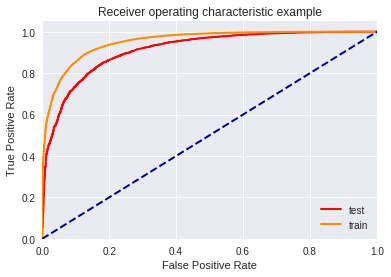

       

TrueNegative : 995
FalsePostive : 1906
FalseNegative : 195
TruePostive  :  16904
        
        


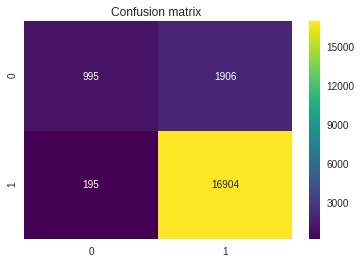

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV

#({'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0.05},

clf1=xgb.XGBClassifier(min_child_weight=1,max_depth=9,reg_alpha=0)
clf1.fit(X_train_bow_xg,y_train_xg)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_bow_xg, y_train_xg)

pred = sig_clf.predict_proba(X_test_bow_xg)[:,1]
pred_train = sig_clf.predict_proba(X_train_bow_xg)[:,1]


pred_train_without_CCV=clf1.predict(X_train_bow_xg)
pred_without_CCV=clf1.predict(X_test_bow_xg)


print("Accuracy Score : ",accuracy_score(y_test_xg,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test_xg,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test_xg,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test_xg,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test_xg,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train_xg,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test_xg,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test_xg,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test_xg,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:
#BoW
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=100) #in scikit-learn
tf_idf_vect.fit(X_train)
print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text BOW vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words ", X_train_tfidf.get_shape()[1])

X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text BOW vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words ", X_test_tfidf.get_shape()[1])

some feature names  ['add', 'alway', 'amazon', 'ani', 'bag', 'becaus', 'befor', 'best', 'better', 'bit']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (32000, 100)
the number of unique words  100
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (8000, 100)
the number of unique words  100


In [0]:
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
clf=GradientBoostingClassifier()
#param_grid={ 'n_estimators' : np.arange(20,200,20),
#             'max_depth' :  [5,10,15,20,30],
#             'learning_rate' : [0.1,0.001] }
param_grid={ 'n_estimators' : [50,100,150,200],
             'max_depth' :  [5,10,20]}
gcv=RandomizedSearchCV(clf,param_grid,cv=5)
gcv.fit(X_train_tfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'n_estimators': 200, 'max_depth': 5}
0.856125


[5, 20, 10, 5, 5, 20, 5, 20, 20, 10]
[50, 50, 100, 200, 100, 200, 150, 150, 100, 200]
[86.0, 98.0, 94.0, 89.0, 88.0, 100.0, 89.0, 100.0, 99.0, 96.0]
[85.0, 85.0, 85.0, 86.0, 85.0, 85.0, 86.0, 85.0, 85.0, 85.0]
ploting 3d grap
ploting Heat Map


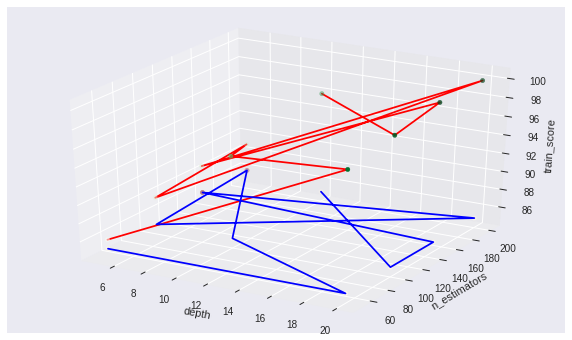

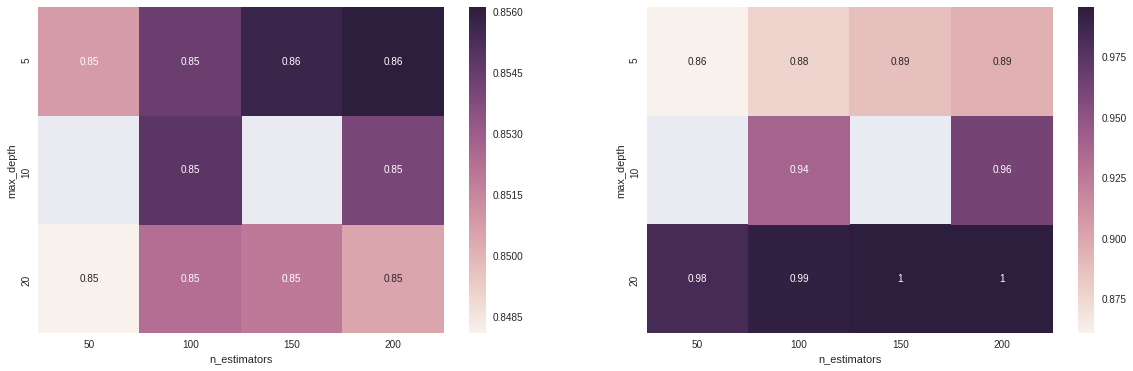

In [0]:





hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()


Accuracy Score :  85.55
Precision Score :  86.70512652419038
Recall Score :  97.8978534418949
F1 Score :  91.96217494089834
        
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.19      0.29      1245
           1       0.87      0.98      0.92      6755

   micro avg       0.86      0.86      0.86      8000
   macro avg       0.74      0.58      0.60      8000
weighted avg       0.83      0.86      0.82      8000

        
AUC Score for train data : 0.9287001619184111
AUC Score for test data : 0.8221434070850389
        


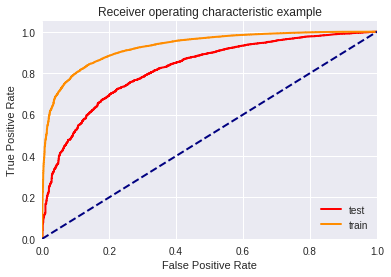

       

TrueNegative : 231
FalsePostive : 1014
FalseNegative : 142
TruePostive  :  6613
        
        


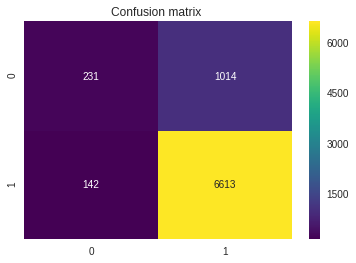

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 



clf1=GradientBoostingClassifier(n_estimators=200,max_depth=5)
clf1.fit(X_train_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_tfidf, y_train)

pred = sig_clf.predict_proba(X_test_tfidf)[:,1]
pred_train = sig_clf.predict_proba(X_train_tfidf)[:,1]


pred_train_without_CCV=clf1.predict(X_train_tfidf)
pred_without_CCV=clf1.predict(X_test_tfidf)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


['great', 'love', 'best', 'did', 'product', 'didnt', 'tast', 'good', 'delici', 'box', 'perfect', 'review', 'ingredi', 'buy', 'dont', 'use', 'look', 'like', 'old', 'onli']


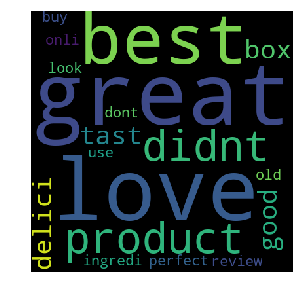

In [0]:

-np.sort(-clf1.feature_importances_)[:20]


features=tf_idf_vect.get_feature_names()
imp=clf1.feature_importances_.argsort()[::-1][:20]
top20Features=[features[i] for i in imp]
top20Features
print(top20Features)

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

wordcloud = WordCloud(width = 400, height = 400, background_color ='black',  min_font_size = 10).generate(' '.join(top20Features))
  
# plot the WordCloud image                        
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
#a=clf1.feature_importances_.tolist()
#a.sort()
#print(a[::-1][:20])

#np.sort(clf1.feature_importances_,)[::-1][:20]
-np.sort(-clf1.feature_importances_)[:50]


features=tf_idf_vect.get_feature_names()
imp=clf1.feature_importances_.tolist()

print([i for i in zip(features,imp)])

df=pd.DataFrame([features,imp],index=['feature','values'])
df=df.T
df1=df.sort_values('values',ascending=False)


print(len(imp))
len(features)
df1[:20]


[('add', 0.004790526336066039), ('alway', 0.006755409983854369), ('amazon', 0.007637441244196877), ('ani', 0.001240021027745022), ('bag', 0.01097278777813433), ('becaus', 0.008490865782628238), ('befor', 0.007121010407324348), ('best', 0.0518310234638379), ('better', 0.0026836321041706713), ('bit', 0.0021805949282548754), ('bottl', 0.003916387653340673), ('bought', 0.009934506296238531), ('box', 0.019888991782301937), ('brand', 0.009004188960466737), ('buy', 0.014510953823906334), ('cat', 0.004328381514334041), ('chocol', 0.0018969214906877742), ('coffe', 0.004425927190579354), ('come', 0.0040088675736611725), ('cup', 0.001177079278719279), ('day', 0.0039654919899103774), ('delici', 0.023150561982927118), ('did', 0.038945296275679706), ('didnt', 0.0315045458600981), ('differ', 0.002880902708370829), ('doe', 0.004914816458537433), ('dog', 0.010642100929520958), ('dont', 0.014388333666259957), ('drink', 0.0019852194333064405), ('eat', 0.007036617687499177), ('enjoy', 0.006820384586415169

,feature,values
38,great,0.0723193
52,love,0.0707939
7,best,0.051831
22,did,0.0389453
68,product,0.0375444
23,didnt,0.0315045
85,tast,0.0293725
36,good,0.0269236
21,delici,0.0231506
12,box,0.019889


### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
	
	
#*******************************************************************************************

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
		
#*******************************************************************************************

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_train_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_AvgW2V.append(sent_vec)
print(len(X_train_AvgW2V))
print(len(X_train_AvgW2V[0]))
#*********************************************************************************************

i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
	
#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_test_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_AvgW2V.append(sent_vec)
print(len(X_test_AvgW2V))
print(len(X_test_AvgW2V[0]))


[('wonder', 0.826174259185791), ('excel', 0.8060868978500366), ('fantast', 0.8010183572769165), ('perfect', 0.7783036231994629), ('good', 0.7774456739425659), ('awesom', 0.7764139771461487), ('terrif', 0.7635849118232727), ('amaz', 0.7019591331481934), ('nice', 0.6454187631607056), ('fabul', 0.6228042840957642)]
[('best', 0.7324355840682983), ('disgust', 0.6967191696166992), ('horribl', 0.6771298050880432), ('closest', 0.6473489999771118), ('nicest', 0.6233989596366882), ('terribl', 0.6099085211753845), ('greatest', 0.6059007048606873), ('tastiest', 0.5827214121818542), ('superior', 0.5721940994262695), ('finest', 0.5604434013366699)]
number of words that occured minimum 5 times  8343
sample words  ['this', 'product', 'better', 'than', 'ani', 'have', 'tri', 'the', 'pure', 'white', 'powder', 'and', 'doe', 'not', 'filler', 'best', 'valu', 'wasabi', 'pea', 'out', 'there', 'bag', 'repres', 'lot', 'but', 'leav', 'work', 'theyll', 'soon', 'disappear', 'tasti', 'first', 'had', 'cooki', 'airli

In [0]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_AvgW2V)
X_train_AvgW2V=scaler.transform(X_train_AvgW2V)

X_test_AvgW2V=scaler.transform(X_test_AvgW2V)

In [0]:
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
clf=GradientBoostingClassifier()
#param_grid={ 'n_estimators' : np.arange(20,200,20),
#             'max_depth' :  [5,10,15,20,30],
#             'learning_rate' : [0.1,0.001] }
param_grid={ 'n_estimators' : [10,100],
             'max_depth' :  [5,10,20]}
gcv=RandomizedSearchCV(clf,param_grid,cv=5)
gcv.fit(X_train_AvgW2V,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'n_estimators': 100, 'max_depth': 5}
0.87915625


[10, 10, 5, 10, 5, 5, 5, 20, 20, 10]
[150, 10, 150, 100, 50, 10, 200, 150, 100, 50]
[100.0, 93.0, 93.0, 100.0, 90.0, 85.0, 94.0, 100.0, 100.0, 100.0]
[88.0, 86.0, 88.0, 88.0, 87.0, 85.0, 88.0, 84.0, 85.0, 88.0]
ploting 3d grap
ploting Heat Map


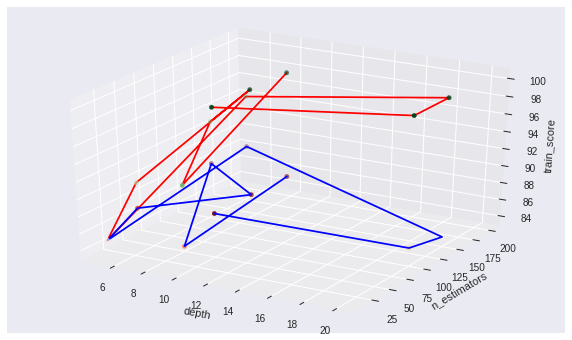

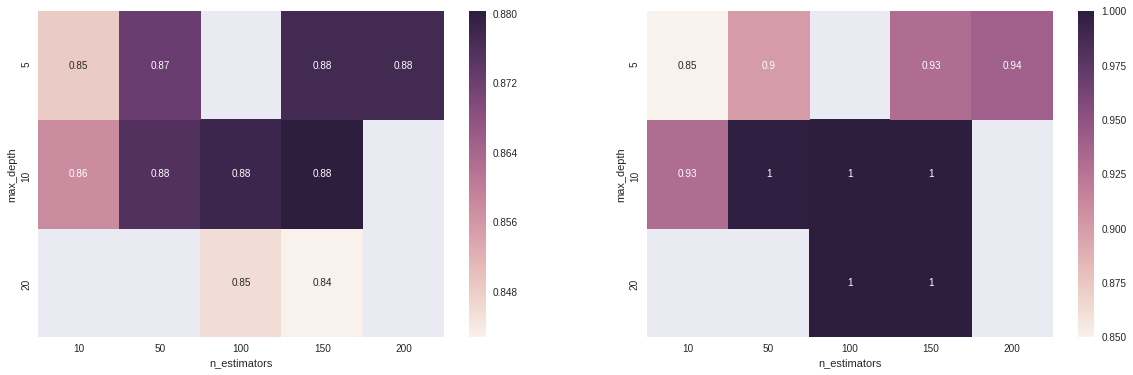

In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()

Accuracy Score :  87.875
Precision Score :  89.62871626250171
Recall Score :  96.84678016284234
F1 Score :  93.09805037711682
        
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.39      0.50      1245
           1       0.90      0.97      0.93      6755

   micro avg       0.88      0.88      0.88      8000
   macro avg       0.80      0.68      0.72      8000
weighted avg       0.87      0.88      0.86      8000

        
AUC Score for train data : 0.9519917924771961
AUC Score for test data : 0.8847887181590908
        


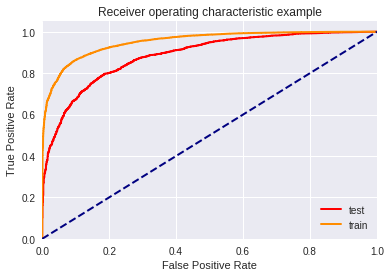

       

TrueNegative : 488
FalsePostive : 757
FalseNegative : 213
TruePostive  :  6542
        
        


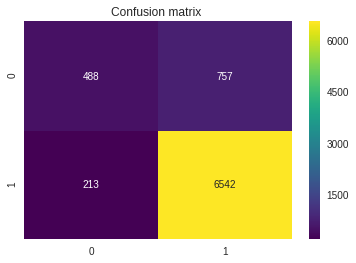

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 
from sklearn.ensemble import GradientBoostingClassifier

clf1=GradientBoostingClassifier(n_estimators=100,max_depth=5)
clf1.fit(X_train_AvgW2V,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_AvgW2V, y_train)

pred = sig_clf.predict_proba(X_test_AvgW2V)[:,1]
pred_train = sig_clf.predict_proba(X_train_AvgW2V)[:,1]


pred_train_without_CCV=clf1.predict(X_train_AvgW2V)
pred_without_CCV=clf1.predict(X_test_AvgW2V)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

#*********************************************************************************************

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_Avgtfidf.append(sent_vec)
    row += 1

    
#*********************************************************************************************

X_test_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_Avgtfidf.append(sent_vec)
    row += 1


In [0]:
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
clf=GradientBoostingClassifier()
#param_grid={ 'n_estimators' : np.arange(20,200,20),
#             'max_depth' :  [5,10,15,20,30],
#             'learning_rate' : [0.1,0.001] }
param_grid={ 'n_estimators' : [10,50,100,200],
             'max_depth' :  [5,10,20]}
gcv=RandomizedSearchCV(clf,param_grid,cv=5)
gcv.fit(X_train_Avgtfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'n_estimators': 200, 'max_depth': 5}
0.8721875


In [0]:
hyperparameters=[(i['max_depth'],i['n_estimators']) for i in gcv.cv_results_['params']]

depth         = [i[0] for i in hyperparameters]
n_estimators  = [i[1] for i in hyperparameters]

train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(depth)
print(n_estimators)
print(train_score)
print(test_score)

print("ploting 3d grap")

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 6))

ax1 = plt.axes(projection='3d')

ax1.plot3D(depth, n_estimators , train_score , 'red',label="train_score")
ax1.set_xlabel('depth')
ax1.set_ylabel('n_estimators')
ax1.set_zlabel('train_score')
#ax1.label_outer()

#ax1.legend()
ax1.scatter3D(depth, n_estimators, train_score , c=train_score, cmap='Greens',label="train_score")

ax1.plot3D(depth, n_estimators , test_score , 'blue',label="test_score")
ax1.scatter3D(depth, n_estimators, test_score , c=test_score, cmap='OrRd',label="test_score")


print("ploting Heat Map")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

results_df=pd.DataFrame(gcv.cv_results_)

#df2=pd.DataFrame(train_score,test_score)

df_params = results_df['params'].apply(pd.Series)

df3=pd.concat([results_df,df_params],axis=1).drop('params',axis=1)
#df3=pd.DataFrame(depth,n_estimators,test_score,train_score)

final_df1_test = df3.pivot("max_depth", "n_estimators", "mean_test_score")
sns.heatmap(final_df1_test, annot=True ,ax=ax1 )



final_df_train = df3.pivot("max_depth", "n_estimators", "mean_train_score")
sns.heatmap(final_df_train, annot=True ,ax=ax2) 

plt.show()
#fig.show()

Accuracy Score :  87.1875
Precision Score :  88.84219088937093
Recall Score :  97.00962250185047
F1 Score :  92.7464439883943
        
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.34      0.45      1245
           1       0.89      0.97      0.93      6755

   micro avg       0.87      0.87      0.87      8000
   macro avg       0.78      0.65      0.69      8000
weighted avg       0.86      0.87      0.85      8000

        
AUC Score for train data : 0.9655638353235834
AUC Score for test data : 0.8657696366517142
        


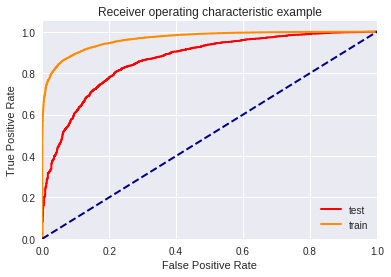

       

TrueNegative : 422
FalsePostive : 823
FalseNegative : 202
TruePostive  :  6553
        
        


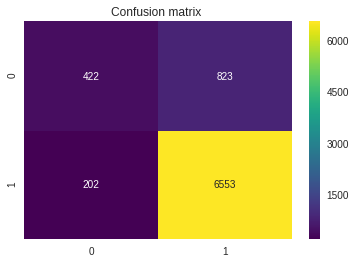

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 
from sklearn.ensemble import GradientBoostingClassifier

clf1=GradientBoostingClassifier(n_estimators=200,max_depth=5)
clf1.fit(X_train_Avgtfidf,y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train_Avgtfidf, y_train)

pred = sig_clf.predict_proba(X_test_Avgtfidf)[:,1]
pred_train = sig_clf.predict_proba(X_train_Avgtfidf)[:,1]


pred_train_without_CCV=clf1.predict(X_train_Avgtfidf)
pred_without_CCV=clf1.predict(X_test_Avgtfidf)


print("Accuracy Score : ",accuracy_score(y_test,pred_without_CCV)*100)
print("Precision Score : ",precision_score(y_test,pred_without_CCV)*100)
print("Recall Score : ",recall_score(y_test,pred_without_CCV)*100)
print("F1 Score : ",f1_score(y_test,pred_without_CCV)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred_without_CCV))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred_without_CCV).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred_without_CCV),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


# [6] Conclusions

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()

print("RandomForest Table")
x.field_names = ["RandomForest with Different Vectorization" , "n_estimators" , "max_depth" , 'Test_Accuracy','F1-Score','AUC_Score']


x.add_row([ "RF with BOW" , 100 ,500  , 85.55 ,  92.01 , 83.13 ])
x.add_row([ "RF with TFIDF" , 100 ,50 , 84.975 , 91.708 ,83.52])
x.add_row([ "Rf with AVG_W2V" , 10 , 100, 85.9,  92.24 ,83.62 ])
x.add_row([ "Rf with AVG_W2VTFIDF" , 455 , 50 , 85.97,  92.27 , 83.86 ])


print(x)

RandomForest Table
+-------------------------------------------+--------------+-----------+---------------+----------+-----------+
| RandomForest with Different Vectorization | n_estimators | max_depth | Test_Accuracy | F1-Score | AUC_Score |
+-------------------------------------------+--------------+-----------+---------------+----------+-----------+
|                RF with BOW                |     100      |    500    |     85.55     |  92.01   |   83.13   |
|               RF with TFIDF               |     100      |     50    |     84.975    |  91.708  |   83.52   |
|              Rf with AVG_W2V              |      10      |    100    |      85.9     |  92.24   |   83.62   |
|            Rf with AVG_W2VTFIDF           |     455      |     50    |     85.97     |  92.27   |   83.86   |
+-------------------------------------------+--------------+-----------+---------------+----------+-----------+


In [3]:
x1 = PrettyTable()

x1.field_names = ["GBDT with Different Vectorization" , "n_estimators" , "max_depth" , 'Test_Accuracy','F1-Score','AUC_Score']

x1.title = "GradientBoostingDescisionTree Table"
x1.add_row([ "XGBOOST with BOW with 100000 rows" , 200 ,10  , 86.8625 ,  92.65 , 91.28])
x1.add_row([ "GDBt with BOW" , 200 ,10  , 86.8625 ,  92.65 , 90.56])
x1.add_row([ "GDBt with TFIDF" , 200 ,5 , 85.475, 91.92,82.214])
x1.add_row([ "GDBt with AVG_W2V" , 100 , 5, 87,  92.79 ,88.47 ])
x1.add_row([ "GDBt with AVG_W2VTFIDF" , 200 , 5 , 85.97,  92.27 , 86.57 ])

print(x1)

+-----------------------------------+--------------+-----------+---------------+----------+-----------+
| GBDT with Different Vectorization | n_estimators | max_depth | Test_Accuracy | F1-Score | AUC_Score |
+-----------------------------------+--------------+-----------+---------------+----------+-----------+
| XGBOOST with BOW with 100000 rows |     200      |     10    |    86.8625    |  92.65   |   91.28   |
|           GDBt with BOW           |     200      |     10    |    86.8625    |  92.65   |   90.56   |
|          GDBt with TFIDF          |     200      |     5     |     85.475    |  91.92   |   82.214  |
|         GDBt with AVG_W2V         |     100      |     5     |       87      |  92.79   |   88.47   |
|       GDBt with AVG_W2VTFIDF      |     200      |     5     |     85.97     |  92.27   |   86.57   |
+-----------------------------------+--------------+-----------+---------------+----------+-----------+


### Summary 
* XGBoost Performs better then than the Random forest
* there is overfit in data at RandomForest w2v tfidf model
* there is less over fit on XG Boost Model